In [1]:
import pandas as pd
import numpy as np
from pgmpy.estimators import ExhaustiveSearch, HillClimbSearch, BdeuScore, K2Score, BicScore, MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.models import BayesianModel
from scipy import stats
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)


In [2]:
data = pd.read_csv('data/processed/bus_network_data_V2.csv')
#feature removal in order to reduce the feature space and make the classification 
#less expensive from a computational point of view

features = [u'bus_line', u'direction',
            #u'date',
            u'month',
            #u'day',
            u'day_of_week',
            u'time_period',
            #u'hour',
            #u'minute',
            #u'trip_time', 
            #u'avg_trip_time',
            #u'std_trip_time', 
            #u'delay_time',
            u'delay', #this is our Y
            u'Conditions', 
            #u'Humidity',
            #u'PrecipitationIn',
            #u'TemperatureF',
            #u'VisibilityMPH',
            #u'Wind SpeedMPH',
            u'totalInjuries', 
            u'pavementScore', 
            u'potholeCount',  
            u'prev_trip_ratio',
            u'ntwk_delay_lag1hr']

data = data.loc[:,features]
data.dropna(inplace = True)

In [3]:
#We reduce some features from continuous to categories. 
#This made an improvement in the accuracy for Multinomial Naive Bayes
data.totalInjuries = pd.cut(data.totalInjuries,3,labels=False)
data.pavementScore = pd.cut(data.pavementScore,3,labels=False)
data.potholeCount = pd.cut(data.potholeCount,3,labels=False)
data.prev_trip_ratio = pd.cut(data.prev_trip_ratio,3,labels=False)


In [4]:
data.head()

,bus_line,direction,month,day_of_week,time_period,delay,Conditions,totalInjuries,pavementScore,potholeCount,prev_trip_ratio,ntwk_delay_lag1hr
0,B11,2.0,1,Friday,PeakAM,on-time,Overcast,0,0,1,0,2.0
1,B11,1.0,1,Friday,PeakAM,on-time,Overcast,0,0,1,0,2.0
2,B11,2.0,1,Friday,MidDay,early,Overcast,0,0,1,0,4.0
3,B11,1.0,1,Friday,MidDay,early,Overcast,0,0,1,0,4.0
4,B11,2.0,1,Friday,MidDay,early,Overcast,0,0,1,0,4.0


# 1- Naive Bayes

In [5]:
#convert data to Naive Bayes compatible
#factor variables
dataNB = data.copy()
dataNB['bus_lineCat'] = pd.Categorical(values=dataNB.bus_line,categories=dataNB.bus_line.unique(),ordered=False).codes
dataNB['day_of_weekCat'] = pd.Categorical(values=dataNB.day_of_week,categories=dataNB.day_of_week.unique(),ordered=False).codes
dataNB['time_periodCat'] = pd.Categorical(values=dataNB.time_period,categories=dataNB.time_period.unique(),ordered=False).codes
dataNB['ConditionsCat'] = pd.Categorical(values=dataNB.Conditions,categories=dataNB.Conditions.unique(),ordered=False).codes

dataNB['delayBinom'] = map(int,((dataNB.delay == 'delay')|(dataNB.delay == 'significant delay')))
dataNB['direction'] = map(int,dataNB.direction)
dataNB['ntwk_delay_lag1hr'] = map(int,dataNB.ntwk_delay_lag1hr)

dataNB.head()


,bus_line,direction,month,day_of_week,time_period,delay,Conditions,totalInjuries,pavementScore,potholeCount,prev_trip_ratio,ntwk_delay_lag1hr,bus_lineCat,day_of_weekCat,time_periodCat,ConditionsCat,delayBinom
0,B11,2,1,Friday,PeakAM,on-time,Overcast,0,0,1,0,2,0,0,0,0,0
1,B11,1,1,Friday,PeakAM,on-time,Overcast,0,0,1,0,2,0,0,0,0,0
2,B11,2,1,Friday,MidDay,early,Overcast,0,0,1,0,4,0,0,1,0,0
3,B11,1,1,Friday,MidDay,early,Overcast,0,0,1,0,4,0,0,1,0,0
4,B11,2,1,Friday,MidDay,early,Overcast,0,0,1,0,4,0,0,1,0,0


In [6]:
#split dataset into 60% training and 40% test 
np.random.seed(2015)
variables = ['bus_lineCat',u'direction',
             u'month', u'totalInjuries',
             u'pavementScore', u'potholeCount', u'ntwk_delay_lag1hr',
             'day_of_weekCat', 'time_periodCat', 'ConditionsCat']

ind=stats.bernoulli.rvs(p = 0.5, size = len(data.index))

X_train=dataNB.loc[ind==1,variables].values
X_test=dataNB.loc[ind==0,variables].values

Y_train = dataNB.loc[ind==1,['delay']].values
Y_trainBinom = dataNB.loc[ind==1,['delayBinom']].values

Y_test = dataNB.loc[ind==0,['delay']].values
Y_testBinom = dataNB.loc[ind==0,['delayBinom']].values


In [7]:
dataNB.delayBinom.value_counts()

0    517158
1    268288
Name: delayBinom, dtype: int64

### Binomial classification

In [8]:
#train model
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

modelBinom = gnb.fit(X_train,Y_trainBinom)



/home/pipe/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
#fit and produce accuracy
(pd.Series(modelBinom.predict(X_test)) ==  pd.Series(Y_testBinom.ravel())).sum()*1./len(pd.Series(Y_testBinom.ravel()))

0.65876705973520133

### Multinomial classification


In [14]:
#train model
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [15]:
#fit and produce accuracy
(Y_test.ravel() == clf.predict(X_test)).sum()*1./len(Y_test.ravel())

0.37168173174474506

# 2- Bayesian networks

Bayesian Networks were really expensive computationaly in our dataset, even using the reduced feature space. So, we didn't pursue this technique further. Nevertheless, here are some of the preliminary results.

First, we try to learn the network from data using Bic Score and Hill Climb algorithm. The code remains commented as it takes several hours to run. Results are stored beneath using 20% of data and 40% after running the code. Nevertheless, resulting networks were not convincing enough.

Also, we design the network by hand stating that everything conditioned delay,  but also with some interactions between variables (like potholes conditioning the pavement score)

Results


## Learn structure from data

In [16]:

#hc = HillClimbSearch(data, scoring_method=BicScore(data))
#best_model = hc.estimate()
#print(best_model.edges())

In [17]:
bayNet20 = [(u'direction', u'delay'), (u'bus_line', u'delay'), (u'bus_line', u'pavementScore'), (u'bus_line', u'direction'), (u'bus_line', u'totalInjuries'), (u'day_of_week', u'time_period'), (u'day_of_week', u'Conditions'), (u'day_of_week', u'ntwk_delay_lag1hr'), (u'day_of_week', u'month'), (u'month', u'totalInjuries'), (u'delay', u'ntwk_delay_lag1hr'), (u'potholeCount', u'bus_line'), (u'time_period', u'potholeCount'), (u'time_period', u'direction'), (u'time_period', u'Conditions'), (u'time_period', u'ntwk_delay_lag1hr'), (u'Conditions', u'month')]
bayNet40 = [(u'pavementScore', u'bus_line'), (u'bus_line', u'potholeCount'), (u'bus_line', u'delay'), (u'bus_line', u'direction'), (u'bus_line', u'ntwk_delay_lag1hr'), (u'bus_line', u'totalInjuries'), (u'day_of_week', u'time_period'), (u'day_of_week', u'Conditions'), (u'month', u'time_period'), (u'month', u'Conditions'), (u'month', u'day_of_week'), (u'month', u'totalInjuries'), (u'delay', u'direction'), (u'delay', u'ntwk_delay_lag1hr'), (u'time_period', u'direction'), (u'time_period', u'Conditions'), (u'ntwk_delay_lag1hr', u'time_period'), (u'ntwk_delay_lag1hr', u'day_of_week'), (u'ntwk_delay_lag1hr', u'month')]


## Ploting networks

In [18]:
#https://networkx.readthedocs.io/en/stable/tutorial/index.html
G=nx.DiGraph()
G.add_edges_from(bayNet20)
print(list(G.nodes()))
print(list(G.edges()))

[u'direction', u'pavementScore', u'bus_line', u'day_of_week', u'month', u'delay', u'totalInjuries', u'potholeCount', u'time_period', u'Conditions', u'ntwk_delay_lag1hr']
[(u'direction', u'delay'), (u'bus_line', u'delay'), (u'bus_line', u'pavementScore'), (u'bus_line', u'direction'), (u'bus_line', u'totalInjuries'), (u'day_of_week', u'time_period'), (u'day_of_week', u'Conditions'), (u'day_of_week', u'ntwk_delay_lag1hr'), (u'day_of_week', u'month'), (u'month', u'totalInjuries'), (u'delay', u'ntwk_delay_lag1hr'), (u'potholeCount', u'bus_line'), (u'time_period', u'potholeCount'), (u'time_period', u'direction'), (u'time_period', u'Conditions'), (u'time_period', u'ntwk_delay_lag1hr'), (u'Conditions', u'month')]


(-1.5, 1.5, -1.5, 1.5)

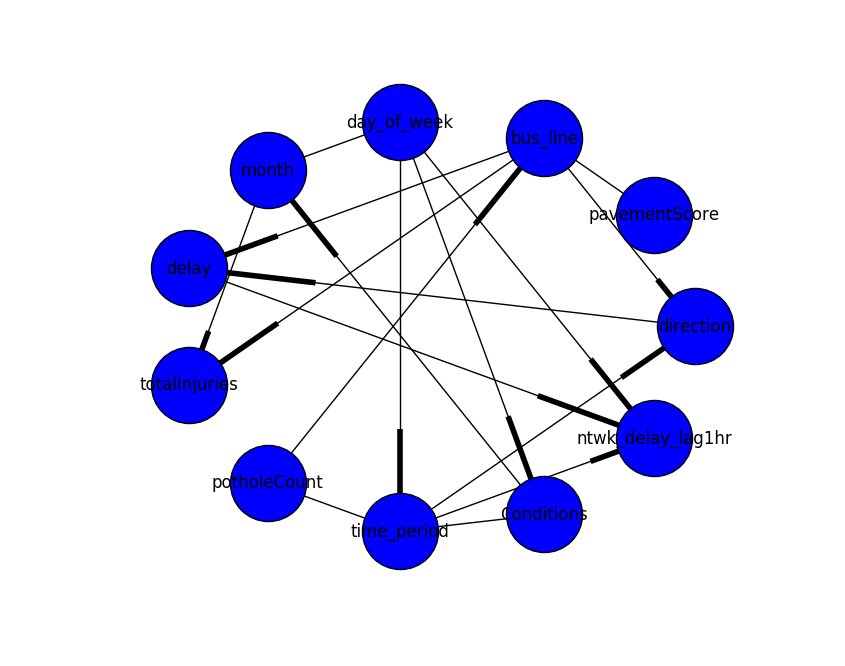

In [19]:
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos,node_color='blue',node_size =3000,nodelist=G.nodes())
nx.draw_networkx_labels(G,pos=pos)
nx.draw_networkx_edges(G,pos=pos,arrows=True)
plt.axis('off')

In [20]:
#https://networkx.readthedocs.io/en/stable/tutorial/index.html
G=nx.DiGraph()
G.add_edges_from(bayNet40)
print(list(G.nodes()))
print(list(G.edges()))

[u'direction', u'day_of_week', u'pavementScore', u'bus_line', u'totalInjuries', u'month', u'delay', u'ntwk_delay_lag1hr', u'potholeCount', u'time_period', u'Conditions']
[(u'day_of_week', u'time_period'), (u'day_of_week', u'Conditions'), (u'pavementScore', u'bus_line'), (u'bus_line', u'potholeCount'), (u'bus_line', u'delay'), (u'bus_line', u'direction'), (u'bus_line', u'ntwk_delay_lag1hr'), (u'bus_line', u'totalInjuries'), (u'month', u'time_period'), (u'month', u'Conditions'), (u'month', u'totalInjuries'), (u'month', u'day_of_week'), (u'delay', u'direction'), (u'delay', u'ntwk_delay_lag1hr'), (u'ntwk_delay_lag1hr', u'time_period'), (u'ntwk_delay_lag1hr', u'day_of_week'), (u'ntwk_delay_lag1hr', u'month'), (u'time_period', u'direction'), (u'time_period', u'Conditions')]


(-1.5, 1.5, -1.5, 1.5)

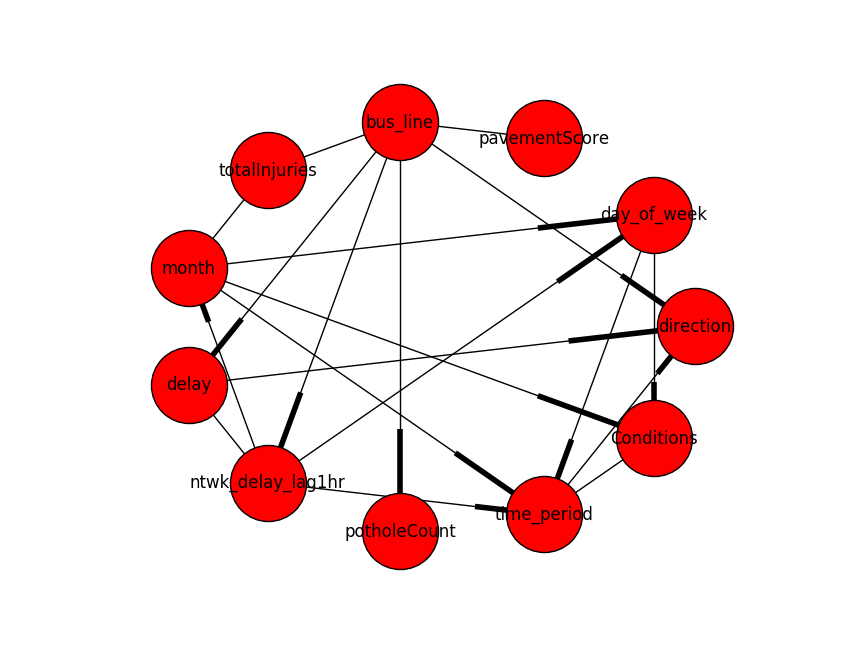

In [21]:
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos,node_color='red',node_size =3000,nodelist=G.nodes())
nx.draw_networkx_labels(G,pos=pos)
nx.draw_networkx_edges(G,pos=pos,arrows=True)
plt.axis('off')

In [22]:
data['weekend'] = ((data.day_of_week == 'Saturday') | (data.day_of_week == 'Saturday'))
data.weekend = data.weekend.map(lambda x: int(x))

data['badConditions'] = data.Conditions.isin(['Heavy Rain','Snow','Heavy Snow '])
data.badConditions = data.badConditions.map(lambda x: int(x))

data.drop(['day_of_week','Conditions'],axis=1,inplace=True)

In [29]:
bayNet = []
for variable in  data.columns:
    if variable != 'delay':
        tupla = (variable,'delay')
        bayNet.append(tupla)
bayNet

[(u'bus_line', 'delay'),
 (u'direction', 'delay'),
 (u'month', 'delay'),
 (u'time_period', 'delay'),
 (u'totalInjuries', 'delay'),
 (u'pavementScore', 'delay'),
 (u'potholeCount', 'delay'),
 (u'prev_trip_ratio', 'delay'),
 (u'ntwk_delay_lag1hr', 'delay'),
 ('weekend', 'delay'),
 ('badConditions', 'delay')]

In [30]:
# We add that pavementScore is dependant on potholeCount
#(actually the DOT score depends on the pothole count and some other variables)
# and that the state of the roads my influence the injuries by car accidents
bayNet.append(('pavementScore','totalInjuries'))
bayNet.append(('potholeCount','pavementScore'))

In [31]:
#model = BayesianModel(bayNet)
#model


In [34]:
# we try to run this with 10% of data as train, but never got any results
#data = data.sample(frac=0.1, replace=False)
#data.shape

In [33]:
# Learing CPDs using Maximum Likelihood Estimators
# model.fit(data, estimator=MaximumLikelihoodEstimator)


In [ ]:
#for cpd in model.get_cpds():
#    print("CPD of {variable}:".format(variable=cpd.variable))
#    print(cpd)
#print model.get_independencies()